In [1]:
import pandas as pd
import numpy as np
from collections.abc import Iterable
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import time
from keras.utils import plot_model
import matplotlib.pyplot as plt

# define gvars
SEED = 1080
VCHUNK = 64
NUM_CLASSES = 12

BATCH_SIZE = 32
SPLIT = 0.2
EPOCHS = 50
LR = 0.001
METRIC = 'val_accuracy'
MIN_DELTA = 1e-4
PATIENCE = 100
THRESHOLD = 0.5

# Set random seed
tf.random.set_seed(SEED)

# import from csv to dataframe
df = pd.read_csv('wnl/WNL_TLS_Dataset_ECH.csv', sep='\t')
esni = pd.read_csv('wnl/WNL_TLS_Dataset_ESNI.csv', sep='\t')

# set checkpoint path and filename
check_name = "WNL_CLASS_GRU.chkp"
check_path = "checkpoint/" + check_name

# define our callbacks
callbacks = [

    # define checkpoint callback
    tf.keras.callbacks.ModelCheckpoint (
        check_path,
        monitor= 'val_accuracy',
        verbose= 1,
        save_best_only= True,
        save_weights_only= True,
        mode= 'auto',
        save_freq='epoch',
        options=None,
        initial_value_threshold=THRESHOLD,
    ),

    # # define early stopping callback
    # tf.keras.callbacks.EarlyStopping(
    #     monitor=METRIC,
    #     min_delta=MIN_DELTA,
    #     patience=PATIENCE,
    #     verbose=1
    # ),

]


2023-04-03 20:58:14.225464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 20:58:14.378523: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-03 20:58:15.012956: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-03 20:58:15.013004: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
'''https://tls13.xargs.org/#client-hello/annotated'''

def flatten(L):
    '''flattens a list of nested list of arbitrary depth into a single concatenated list'''
    for x in L:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x

def padding(A, size):
    '''pads a given list to a given length'''
    t = size - len(A)

    return np.pad(A, pad_width=(0, t), mode='constant')

def parse_CHP(p):
    '''
    implements the Shamsimukhametov et al. bytes recomposition algorithm
    builds a fixed length feature vector from clienthello message
    '''
    T = []
    L = []
    V = []

    handshake_len = sum(p[3:5])
    clienthello_len = sum(p[6:9])
    sid_len = p[43]
    i = 44+sid_len

    sid = p[44:i]
    ciphersuite_len = sum(p[i:i+2])
    ciphersuite = p[i+2:i+2+ciphersuite_len]
    i += 4 + ciphersuite_len

    ext_len = sum(p[i:i+2])
    i = i+2
    
    T.append(padding(sid, 32))
    L.append(handshake_len)
    L.append(clienthello_len)
    L.append(sid_len)
    L.append(ciphersuite_len)
    L.append(ext_len)
    V.append(ciphersuite)
    
    end = i + ext_len
    count = 0   

    while (i < len(p)):

        n_ext_id = sum(p[i:i+2])
        i+=2
        
        n_ext_len = sum(p[i:i+2])
        i+=2

        T.append(n_ext_id)
        L.append(n_ext_len)
        V.append(p[i:i+n_ext_len])
        i+=n_ext_len

    T = padding(list(flatten(T)),40)
    L = padding(list(flatten(L)),13)
    V = list(flatten(V))
    VC = V[:VCHUNK]

    return np.concatenate((T,L,VC))

def parse_SHP(p):
    '''
    implements the Shamsimukhametov et al. bytes recomposition algorithm
    builds a fixed length feature vector from serverhello message
    '''
    T = []
    L = []
    V = []

    handshake_len = sum(p[3:5])
    serverhello_len = sum(p[6:9])
    sid_len = p[43]
    i = 44+sid_len

    sid = p[44:i]
    ciphersuite = sum(p[i:i+2])
    i += 3

    ext_len = sum(p[i:i+2])
    i = i+2
    
    T.append(padding(sid, 32))
    T.append(ciphersuite)
    L.append(handshake_len)
    L.append(serverhello_len)
    L.append(sid_len)
    L.append(ext_len)

    end = i + ext_len
    count = 0    
    
    while (i < len(p)):

        n_ext_id = sum(p[i:i+2])
        i+=2
        
        n_ext_len = sum(p[i:i+2])
        i+=2

        T.append(n_ext_id)
        L.append(n_ext_len)
        V.append(p[i:i+n_ext_len])
        i+=n_ext_len

    T = padding(list(flatten(T)),40)
    L = padding(list(flatten(L)),10)
    V = list(flatten(V))
    VC = V[:VCHUNK]

    return np.concatenate((T,L,VC))

def parse_payload(CH,SH):
    '''builds a concatenated fixed length feature vector of recomposed bytes'''
    chp  = np.fromstring(CH, dtype=int, sep=',')
    shp  = np.fromstring(SH, dtype=int, sep=',')
    chv = parse_CHP(chp)
    shv = parse_SHP(shp)
    return np.concatenate((chv,shv))

In [3]:
# Transform according to recomposition algorithm
df['X'] = df.apply(lambda row : parse_payload(row['ClientHello'], row['ServerHello']), axis=1)

In [4]:
# Encode classes into integers as terget variable vector y
labels = df.Label.unique()
df['Label'] = df['Label'].astype('category')
df['target'] = df['Label'].cat.codes
y = df['target'].to_numpy()

In [5]:
# expand array to proper dims
dfx = pd.DataFrame(df['X'].tolist()).add_prefix("x")
X = dfx.to_numpy(dtype=np.int16)
X = X/256


In [6]:
# split the training data into train and val_test sets using categorical stratification
X_train, X_val_test, y_train , y_val_test = train_test_split(   X,
                                                                y,
                                                                stratify=y,
                                                                shuffle=True,
                                                                test_size=SPLIT,
                                                                random_state=SEED
                                                                )

# split the val_test data into val and test sets using categorical stratification
X_val, X_test, y_val , y_test = train_test_split(       X_val_test,
                                                        y_val_test,
                                                        test_size=0.5,
                                                        random_state=SEED
                                                        )
# get sizes
len_a = len(X_train)
len_b = len(X_train[5])

# reshape to fit the model
X_train = tf.reshape(X_train,(len_a,len_b,1))

# check for data leakage
print('Data Leak Check')
# need method to check for duplicate rows in data
print(len(X_train))
print(len(X_val))
print(len(X_test))
print(len(X_train), len(y_train), len(X_val_test), len(y_val_test), len(X_val), len(X_test), len(y_val), len(y_test)), print(len(X_train[5]))

Data Leak Check
2792
349
349
2792 2792 698 698 349 349 349 349
231


2023-04-03 20:58:16.835680: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-03 20:58:16.852010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-03 20:58:16.852157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-03 20:58:16.852546: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

(None, None)

In [7]:
# compose the model architecture function
def compose_model():
    in_layer = layers.Input(shape=(len_b,1))
    x = layers.Bidirectional(layers.GRU(256, return_sequences=True))(in_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D()(x)
    x = layers.Bidirectional(layers.GRU(128, return_sequences=True))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D()(x)
    x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D()(x)
    
    # generic stacked dense softmax classifier
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(len_b, activation='relu')(x)
    x = layers.Dropout(0.25)(x)
    out_layer = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=in_layer, outputs=out_layer)

# instantiate the model
model = compose_model()

# load previously trained weights
#status = model.load_weights(check_path).expect_partial()

# inspect model stack
print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 231, 1)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 231, 512)         397824    
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 231, 512)         2048      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 115, 512)         0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 115, 256)         493056    
 nal)                                                        

In [8]:
# compile and fit the model to the data
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              metrics=['accuracy'])

# save model plot
plot_model(model, to_file='BDGRU.png')

# start timer
start = time.time()

# fit the model
history = model.fit (   X_train, y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=(X_val, y_val),
                        verbose=1,
                        callbacks=callbacks,
                        )
# stop timer
end = time.time()

Epoch 1/50


2023-04-03 20:58:23.317437: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-04-03 20:58:23.458823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-03 20:58:23.460165: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55ad63335240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-03 20:58:23.460178: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-04-03 20:58:23.463115: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-03 20:58:23.541627: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime 

87/88 [============================>.] - ETA: 0s - loss: 1.9102 - accuracy: 0.3455
Epoch 1: val_accuracy did not improve from 0.50000
88/88 [==============================] - 10s 39ms/step - loss: 1.9092 - accuracy: 0.3453 - val_loss: 2.3947 - val_accuracy: 0.0602
Epoch 2/50
87/88 [============================>.] - ETA: 0s - loss: 1.1738 - accuracy: 0.5585
Epoch 2: val_accuracy did not improve from 0.50000
88/88 [==============================] - 3s 29ms/step - loss: 1.1724 - accuracy: 0.5591 - val_loss: 2.4232 - val_accuracy: 0.0802
Epoch 3/50
87/88 [============================>.] - ETA: 0s - loss: 0.8366 - accuracy: 0.6832
Epoch 3: val_accuracy did not improve from 0.50000
88/88 [==============================] - 3s 29ms/step - loss: 0.8370 - accuracy: 0.6830 - val_loss: 2.6383 - val_accuracy: 0.0774
Epoch 4/50
87/88 [============================>.] - ETA: 0s - loss: 0.6881 - accuracy: 0.7277
Epoch 4: val_accuracy did not improve from 0.50000
88/88 [==============================] -

In [9]:
# Make predictions on our test data
y_pred = model.predict(X_test)
y_pred = np.rint(y_pred)
y_pred = np.argmax(y_pred, axis=1)
print(y_pred)

11/11 [==============================] - 1s 10ms/step
[ 0  9  9  9  9  1  9  9  9  6  4  9  5  9  4 11  7  9  6  6  2  9 10  6
 10  0  0  9  9  4 11  0  9  9 10 11 11 11  7 11  4  1  7  1 10  4  9  9
  9  9  9  0  4  0  6  0 11  4  2  9  6 10  7  4  2  0 11  0  6  9 10  6
  6  9  9  5 10  7  8  4  8  4 10  5  4 10  1  0  7  0  9  9  1  2  9 10
 10  9  9  4  6  7  5  1 11 11  5  9  0  9  7 10  9  9  4  5  1 10  9  1
  5  4  7 11 10  4  0  9  1  2  9  4  1  9  1  6  3  4 11  5  2  6  3  9
  9  1  0  4  9  9  3  4 10  2  0 11 10  1  5  0  7  9  4  5 10  9 10  6
  9  1  5  7  5  2  7 10  4  9 10  1  9 11 11  7  6  3 10  3 10  2  6 11
  6  9  1  2  1  9  9  0  9  1  1  9 11  0  7  0  6  9  4 10 10 10  7  0
  9  4  0 11  5  1  7  7  4  5  9  3 10 11  9  9  6 10  1 10 10 10 11  9
 11  3  9  7  1  9  3 10  9  6  0  9  4 10 11  6 11  6  8  9  9 11  7  9
  0 10  0  4  7  9 10  7 11  4  6 11  5  9  4  9  6  9  9 10 11  4  2  4
  3  9  4  6  4  6  9  6 10  4  5  9  2  9 10  9 10  9  1  9  9  7  9 

In [10]:
# Evaluate the models performance (I hope this isnt garbage)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

  AppleMusic     0.6786    0.9048    0.7755        21
         Web     0.8214    0.7667    0.7931        30
   Kinopoisk     1.0000    1.0000    1.0000        12
LiveFacebook     1.0000    1.0000    1.0000        10
 LiveYouTube     0.8333    0.7692    0.8000        39
     Netflix     0.9444    0.9444    0.9444        18
  PrimeVideo     0.9375    1.0000    0.9677        30
  SoundCloud     0.8462    1.0000    0.9167        22
     Spotify     1.0000    0.5000    0.6667         6
       Vimeo     0.8452    0.7717    0.8068        92
 YandexMusic     0.8140    0.8537    0.8333        41
     YouTube     0.9655    1.0000    0.9825        28

    accuracy                         0.8596       349
   macro avg     0.8905    0.8759    0.8739       349
weighted avg     0.8633    0.8596    0.8578       349



In [11]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Training Time: "+str(end-start))

Accuracy: 0.8595988538681948
Training Time: 139.49201035499573


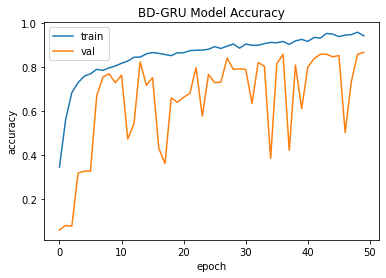

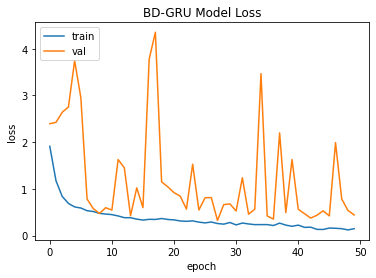

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BD-GRU Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('bdgru_acc.jpg')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BD-GRU Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('bdgru_loss.jpg')
plt.show()